In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import os
import xarray as xr

# Lazy load the 90m DEM ZARR file and select a sub-region

The 90m DEM used here is available at:
https://common.s3.sbg.perf.cloud.ovh.net/adf.html
under the filename: S00__ADF_DEM90_20000101T000000_21000101T000000_20240605T132601.zarr.zip

Only the ‘height_50S_50N‘ region is used in this notebook, it represents 35GB.

In [2]:
# Open the .zarr folder as a dataset
ds = xr.open_zarr("../../DEM/S00__ADF_DEM90_20000101T000000_21000101T000000_20240605T132601.zarr", consolidated=True)
print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:          (latitude: 216000, longitude_50_60: 288001,
                      longitude_00_50: 432001, longitude_60_70: 216001,
                      longitude_70_80: 144001, longitude_80_85: 86401,
                      longitude_85_90: 43201)
Coordinates:
  * latitude         (latitude) float32 864kB 3.24e+05 3.24e+05 ... -3.24e+05
  * longitude_00_50  (longitude_00_50) float32 2MB -6.48e+05 ... 6.48e+05
  * longitude_50_60  (longitude_50_60) float32 1MB -6.48e+05 ... 6.48e+05
  * longitude_60_70  (longitude_60_70) float32 864kB -6.48e+05 ... 6.48e+05
  * longitude_70_80  (longitude_70_80) float32 576kB -6.48e+05 ... 6.48e+05
  * longitude_80_85  (longitude_80_85) float32 346kB -6.48e+05 ... 6.48e+05
  * longitude_85_90  (longitude_85_90) float32 173kB -6.48e+05 ... 6.48e+05
Data variables:
    height_50N_60N   (latitude, longitude_50_60) float32 249GB ...
    height_50S_50N   (latitude, longitude_00_50) float32 373GB ...
    height_60N_70N   (lati

In [3]:
lat_min, lat_max = 30, 50
lon_min, lon_max = -10, 20

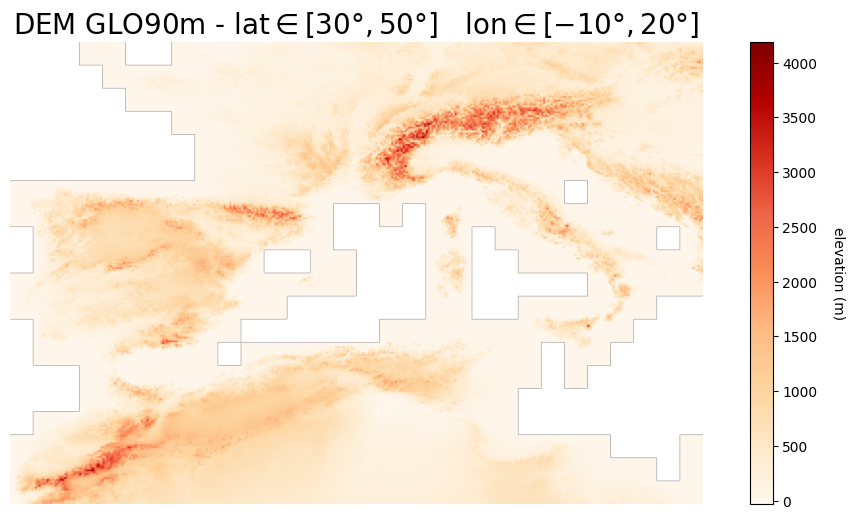

In [4]:
subsampling = 100
plt.figure(figsize=(12,6))
plt.imshow(ds.sel(latitude=slice(324000*(lat_max/90), 
                                 324000*(lat_min/90), subsampling), 
                  longitude_00_50=slice(648000*(lon_min/180), 
                                        648000*(lon_max/180), subsampling))['height_50S_50N'].values[:-1,:-1],
           cmap='OrRd')
plt.axis('off')
plt.title(r'DEM GLO90m - lat$\in [{:}°, {:}°]$   lon$\in[{:}°, {:}°]$'.format(lat_min, lat_max, lon_min, lon_max), fontsize=20) 
cbar = plt.colorbar()
cbar.set_label('elevation (m)', rotation=270, labelpad=20)
plt.show()

# Compute the associated max incidence map

## Define some functions

In [5]:
def cotan_deg(epsilon):
    return 1 / np.tan(np.deg2rad(epsilon))

def get_radius_from_max_incidence_deg(max_incidence_deg, max_elevation_delta):
    assert max_elevation_delta >= 0
    return np.tan(np.deg2rad(max_incidence_deg)) * max_elevation_delta

def slope_to_incidence_deg(slope):
    return np.rad2deg(np.pi/2 - np.arctan(slope))

def get_distance_kernel(radius, pixel_size_lat, pixel_size_lon):
    radius_pix_lat = np.int64(1 + radius / pixel_size_lat) # 1 + for safety reasons if elevation_delta=0
    radius_pix_lon = np.int64(1 + radius / pixel_size_lon) # 1 + for safety reasons if elevation_delta=0
    distance_kernel = np.sqrt(np.sum(np.asarray(np.meshgrid(pixel_size_lon*np.arange(-radius_pix_lon,radius_pix_lon+1,1),
                                                            pixel_size_lat*np.arange(-radius_pix_lat,radius_pix_lat+1,1)))**2, axis=0))
    distance_kernel[radius_pix_lat, radius_pix_lon] = np.inf # fine because later we compute 0 / inf = 0 -> central point will give a slope of 0.
    return distance_kernel

@numba.njit(parallel=True)
def compute_critical_incidence_numba(elevation, distance_kernel, borders=None, verbose=False):
    radius_pix_lat = distance_kernel.shape[0] // 2
    radius_pix_lon = distance_kernel.shape[1] // 2

    if borders is not None:
        assert borders.shape[0] - elevation.shape[0] == borders.shape[1] - elevation.shape[1]
        assert (borders.shape[0] - elevation.shape[0]) % 2 == 0
        shift = (borders.shape[0] - elevation.shape[0]) // 2
        assert max(radius_pix_lat, radius_pix_lon) < shift
    
    critical_incidence = np.nan * np.ones(elevation.shape)

    if borders is None: 
        for row in numba.prange(elevation.shape[0]):
            print(row, elevation.shape[0]) if row % 100 == 0 and verbose else None
            for col in range(elevation.shape[1]):
                critical_incidence[row, col] = np.rad2deg(np.pi/2 - np.arctan(
                    np.nanmax(
                        (elevation[
                         max(row-radius_pix_lat,0):min(row+radius_pix_lat+1,elevation.shape[0]), 
                         max(col-radius_pix_lon,0):min(col+radius_pix_lon+1,elevation.shape[1])] 
                         - elevation[row, col]) / distance_kernel[
                        max(row-radius_pix_lat,0)-row+radius_pix_lat:min(row+radius_pix_lat+1,elevation.shape[0])-row+radius_pix_lat,
                        max(col-radius_pix_lon,0)-col+radius_pix_lon:min(col+radius_pix_lon+1,elevation.shape[1])-col+radius_pix_lon]
                        )
                ))
    else:
        for row in numba.prange(elevation.shape[0]):
            print(row, elevation.shape[0]) if row % 100 == 0 and verbose else None
            for col in range(elevation.shape[1]):
                critical_incidence[row, col] = np.rad2deg(np.pi/2 - np.arctan(
                    np.nanmax(
                        (borders[
                         row-radius_pix_lat+shift:row+radius_pix_lat+1+shift, 
                         col-radius_pix_lon+shift:col+radius_pix_lon+1+shift] 
                         - elevation[row, col]) / distance_kernel
                        )
                ))

    return critical_incidence
    
def get_region_name(region, max_incidence_deg):
    return "S{:}_N{:}_O{:}_E{:}_imax{:}".format(*region, max_incidence_deg)

def compute_region(region, 
                   pixel_size_lat=92.6, # m
                   max_incidence_deg=70, 
                   verbose=2):
    lat_min, lat_max, lon_min, lon_max = region
    subset = ds.sel(latitude=slice(324000*(lat_max/90), 324000*(lat_min/90)), 
                    longitude_00_50=slice(648000*(lon_min/180), 648000*(lon_max/180)))
    subset_larger = ds.sel(latitude=slice(324000*((lat_max+.5)/90), 324000*((lat_min-.5)/90)), 
                           longitude_00_50=slice(648000*((lon_min-.5)/180), 648000*((lon_max+.5)/180)))
    
    elevation = subset['height_50S_50N'].values[:-1,:-1]
    elevation_larger = subset_larger['height_50S_50N'].values[:-1,:-1]
    if verbose > 0 and np.all(np.isnan(elevation)):
        print("WARNING EMPTY REGION")
    assert not np.all(np.isnan(elevation))
        
    pixel_size_lon = np.cos(np.deg2rad(.5*(lat_max+lat_min))) * pixel_size_lat # m
    
    radius = get_radius_from_max_incidence_deg(max_incidence_deg=max_incidence_deg, 
                                               max_elevation_delta=np.nanmax(elevation)-np.nanmin(elevation)) # m
    
    distance_kernel = get_distance_kernel(radius=radius, pixel_size_lat=pixel_size_lat, pixel_size_lon=pixel_size_lon)

    if verbose >= 2:
        plt.imshow(elevation[::10,::10]), plt.colorbar(), plt.show()
    
    if verbose >= 1:
        print("    Elevation Shape:", elevation.shape)
        print("    Min elevation:", np.nanmin(elevation))
        print("    Max elevation:", np.nanmax(elevation))
        print("    Radius (km): ", radius*1e-3)
        print("    Kernel shape (lat, lon): ", distance_kernel.shape)

    start = time.perf_counter()
    critical_incidence = compute_critical_incidence_numba(elevation, 
                                                          distance_kernel=distance_kernel, 
                                                          borders=elevation_larger, 
                                                          verbose=True if verbose>=2 else False)
    end = time.perf_counter()
    if verbose >= 1:
        print(f"Elapsed time: {end - start:.2f} seconds")

    outputfile = "../../DEM/GLO90_critical_incidence_maps/{:}.npy".format(get_region_name(region, max_incidence_deg))
    np.save(outputfile, critical_incidence.astype(np.float16), allow_pickle=True)

    if verbose >= 1:
        print(f"Saved to: ", outputfile)

try:
    os.mkdir("../../DEM/GLO90_critical_incidence_maps")
except FileExistsError:
    pass

print("Critical incidence maps will be saved at ../../DEM/GLO90_critical_incidence_maps/")

Critical incidence maps will be saved at ../../DEM/GLO90_critical_incidence_maps/


## Compute the maps chunk by chunk 

In [6]:
regions = []
for lat in range(lat_min, lat_max):
    for lon in range(lon_min, lon_max):
        regions.append((lat, lat+1, lon, lon+1))
done = []
fails = []

In [7]:
# define the maximum incidence in degrees
# a pixel having a true critical incidence value larger than max_incidence_deg will be computed with a cropped neighboring kernel
# therefore the computed critical incidence for such pixel cannot be fully trusted
# but we know for sure that the true critical incidence for such pixel remains larger than max_incidence_deg
max_incidence_deg = 70 

In [8]:
for region in regions:
    print("\n\n=====================================\n=====================================\nStarting region: ", region)
    if not region in done or region in fails:
        try:
            compute_region(region, 
                           pixel_size_lat=92.6, # m
                           max_incidence_deg=max_incidence_deg, 
                           verbose=1)
            done.append(region)
            print("************* Done region: ", region)
        except:
            fails.append(region)
            print("xxxxxxxxxxxxx Failed region: ", region)
    else:
        print("-------------- Skipping region: ", region)



Starting region:  (30, 31, -10, -9)
    Elevation Shape: (1200, 1200)
    Min elevation: 0.0
    Max elevation: 1911.6329
    Radius (km):  5.252168322017707
    Kernel shape (lat, lon):  (115, 133)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Elapsed time: 7.76 seconds
Saved to:  ../../DEM/GLO90_critical_incidence_maps/S30_N31_O-10_E-9_imax70.npy
************* Done region:  (30, 31, -10, -9)


Starting region:  (30, 31, -9, -8)
    Elevation Shape: (1200, 1200)
    Min elevation: 165.3446
    Max elevation: 3594.0476
    Radius (km):  9.420284413950997
    Kernel shape (lat, lon):  (205, 239)
Elapsed time: 19.28 seconds
Saved to:  ../../DEM/GLO90_critical_incidence_maps/S30_N31_O-9_E-8_imax70.npy
************* Done region:  (30, 31, -9, -8)


Starting region:  (30, 31, -8, -7)
    Elevation Shape: (1200, 1200)
    Min elevation: 550.79987
    Max elevation: 3243.7634
    Radius (km):  7.398856745733995
    Kernel shape (lat, lon):  (161, 187)
Elapsed time: 11.89 seconds
Saved to:  ../../DEM/GLO90_critical_incidence_maps/S30_N31_O-8_E-7_imax70.npy
************* Done region:  (30, 31, -8, -7)


Starting region:  (30, 31, -7, -6)
    Elevation Shape: (1200, 1200)
    Min elevation: 537.6442
    Max elevation: 2212.532
    Radi

# Results

## Loading results

In [9]:
loading_subsampling = 1
critical_incidence = np.nan * np.ones((1200*(lat_max-lat_min)//loading_subsampling, 
                                       1200*(lon_max-lon_min)//loading_subsampling), 
                                      dtype=np.float16)

In [10]:
for lat in range(lat_min, lat_max):
    for lon in range(lon_min, lon_max):
        region = (lat, lat+1, lon, lon+1)
        try:
            critical_incidence[
            1200*(lat_max-lat-1)//loading_subsampling:1200*(lat_max-lat)//loading_subsampling,
            1200*(lon-lon_min)//loading_subsampling:1200*(lon+1-lon_min)//loading_subsampling] = np.load("../../DEM/GLO90_critical_incidence_maps/{:}.npy".format(get_region_name(region, max_incidence_deg)))[::loading_subsampling,::loading_subsampling]
            #print("Loaded region: ", region)
        except:
            #print("xxxxxxxxxxxxxxxx Failed region: ", region)
            pass

In [11]:
## Making sure that critical incidences above max_incidence_deg are not misunderstood as explained above
critical_incidence[critical_incidence>max_incidence_deg] = max_incidence_deg

In [12]:
plot_subsampling = 10 // loading_subsampling

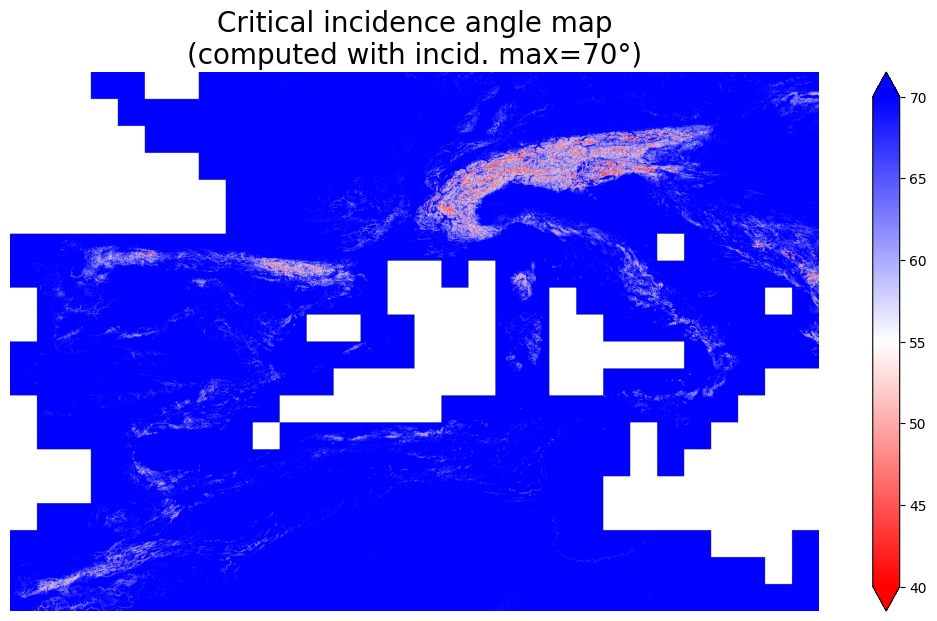

In [13]:
plt.figure(figsize=(14,7))
plt.imshow(critical_incidence[::plot_subsampling,::plot_subsampling], vmin=40, cmap='bwr_r')
plt.axis('off')
plt.title('Critical incidence angle map\n(computed with incid. max={:}°)'.format(max_incidence_deg), fontsize=20)
plt.colorbar(extend='both')
plt.show()

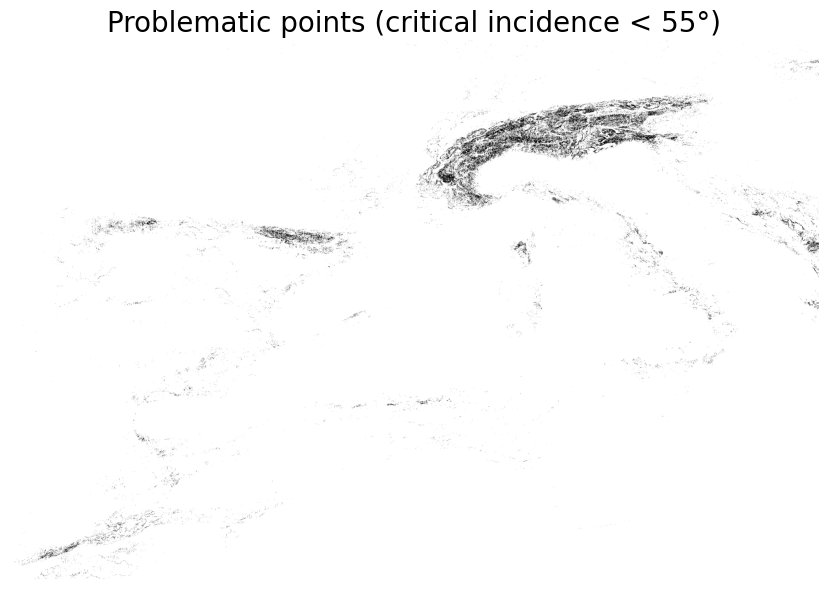

In [14]:
plt.figure(figsize=(14,7))
plt.imshow(critical_incidence[::plot_subsampling,::plot_subsampling] <= 55, cmap='gray_r')
plt.axis('off')
plt.title('Problematic points (critical incidence < 55°)', fontsize=20)
plt.show()

In [15]:
hist_subsampling = plot_subsampling

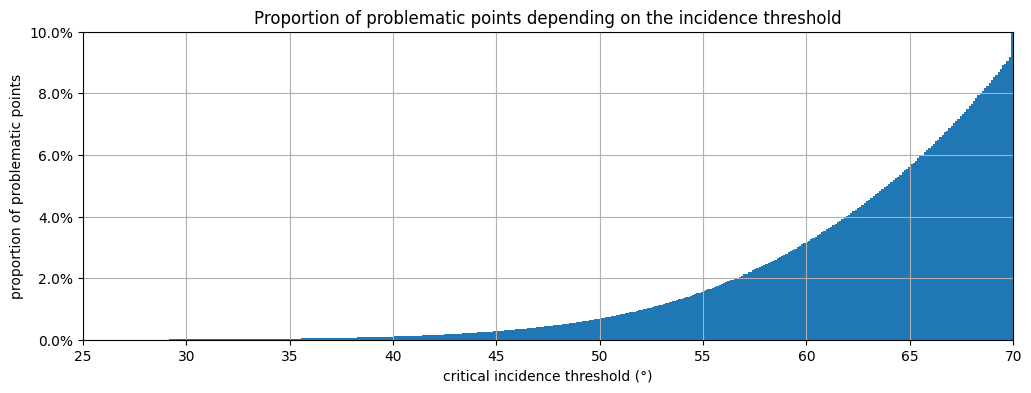

In [16]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(12,4))
plt.grid(True, which="major")
plt.hist(critical_incidence[::hist_subsampling,::hist_subsampling][~np.isnan(critical_incidence[::hist_subsampling,::hist_subsampling])].flatten(), 
         cumulative=True, bins=500, density=True)
plt.xlim(25, max_incidence_deg), plt.ylim(0,0.1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('critical incidence threshold (°)')
plt.ylabel('proportion of problematic points')
plt.title('Proportion of problematic points depending on the incidence threshold')
plt.show()

In [17]:
refine_hist_subsampling = 1

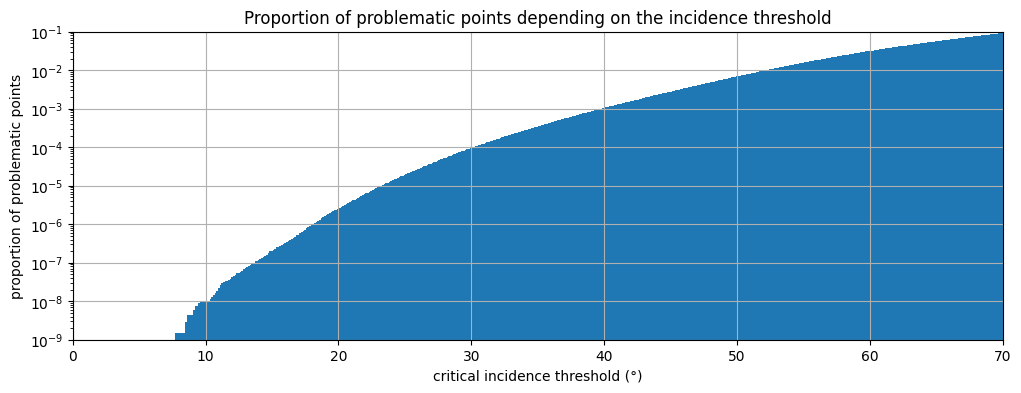

In [18]:
plt.figure(figsize=(12,4))
plt.hist(critical_incidence[::refine_hist_subsampling,::refine_hist_subsampling][~np.isnan(critical_incidence[::refine_hist_subsampling,::refine_hist_subsampling])].flatten(), 
         cumulative=True, bins=500, density=True, log=True)
plt.grid(True)
plt.xlim(0, max_incidence_deg), plt.ylim(1e-9,1e-1)

plt.xlabel('critical incidence threshold (°)')
plt.ylabel('proportion of problematic points')
plt.title('Proportion of problematic points depending on the incidence threshold')
plt.show()